In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import patsy

import numpy as np
import os
from collections import Counter

In [3]:
dblp_dir = "/hg190/corpora/academic-data/dblp/stats/"
dblp_features_file = os.path.join (dblp_dir, "dblp.feats_manual.complete")

In [46]:
df_dblp = pd.read_csv(dblp_features_file)
print (len (df_dblp))
print(df_dblp['indeg'].max())
df_dblp.head(3)

2408010
42508


,docid,indeg,outdeg,year,nauthors,nuniqs,ntokens,lang,bows,nprog,...,max_reg,max_reg_word,nprog99,nprog95,nprog90,nprog50,nreg99,nreg95,nreg90,nreg50
0,35b7f3ac-25dd-4b4e-8c46-adeac09aba54,92,0,1949,2,92,152,en,11.524227,5,...,-1.476099,regenerating,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,4.000000
1,b17b90b3-6ee1-4226-8420-b914f8fa88dc,47,1,1950,2,158,515,en,16.430503,2,...,-1.332051,sort,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2,01c6a1a9-3c59-42fa-9a27-d26cdcb9957c,0,0,1950,1,162,372,en,5.324948,1,...,-1.926402,mi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
3,ad87498e-7a57-4076-88ba-8be4f5032293,50,0,1951,1,53,79,en,12.332035,1,...,0.254160,inner,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,95031834-3520-4151-b0ba-eabb7ec082cf,0,0,1952,1,84,121,en,11.694387,1,...,2.012727,deep,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5,9a6893a1-d15e-4ece-b919-5bac85711b87,50,1,1953,1,102,223,en,-0.040050,1,...,-0.368087,spectrum,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
6,ec94cddb-b89b-483a-8254-1d4ccfb5dca6,1,1,1953,1,46,61,en,8.455391,0,...,-inf,UNK,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,8dc7b347-e77c-46f6-ae89-1ad89607239f,12,0,1953,1,66,119,en,12.716166,1,...,0.015638,branch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
8,b399d0fa-aa41-414d-b002-f207d72a4fbf,110,0,1953,1,155,314,en,8.140402,2,...,-1.500011,pattern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
9,bdeb48c4-20d6-42dd-8de3-092c09c5c090,50,0,1953,1,192,453,en,1.214490,3,...,-0.716116,sub,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000


**Filter**

- Keep only English language records.
- Remove records that contain exactly 50 citations (I had plotted a histograms and it seems there was some discrepancy with this value -- better just remove it)

**Transform**
- Add an extra column for age.
- Add an extra column for not containing any semantic words.

In [47]:
print (len(df_dblp[(df_dblp["lang"] == "en") & (df_dblp["indeg"] != 50)]))
df_dblp = df_dblp[(df_dblp["lang"] == "en") & (df_dblp["indeg"] != 50)]

1671606


In [48]:
df_dblp["age"] = 2019 - df_dblp["year"]
df_dblp["isUNK"] = (df_dblp["max_prog_word"] == "UNK").astype(int)

In [49]:
# for simplicity of descriptive analysis, let's remove docs which don't hit the lexicon
# In the regression we will have to add a dummy variable to account for this.
drop_misses = True
if drop_misses:
    df_dblp = df_dblp[df_dblp["isUNK"] == 0]
print (len(df_dblp))

1511088


**Descriptive analysis**

In [50]:
# quartile-ish bins of the innovation feature  
df_dblp['max_prog_q'] = pd.qcut(df_dblp['max_prog'],4, labels=["<25", "<50", "<75", "<100"], duplicates='drop')
# custom bins of the innovation feature  
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 3), (3, 20)], closed="left")
df_dblp['nprog95_q'] = pd.cut (df_dblp["nprog95"], bins=bins, labels=["0", "<=2", "3+"], retbins=False, duplicates="drop")

Text(0, 0.5, 'Citations')

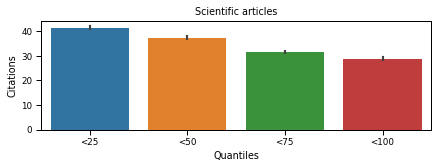

In [51]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[7,2],sharey=True)

#sns.barplot(y='indeg',x='sem_q',data=df_ops,ax=ax[0]);
#ax[0].set_title('Legal opinions')
#ax[0].set_xlabel('Quantiles')
#ax[0].set_ylabel('Citations')
sns.barplot(y='indeg',x='max_prog_q',data=df_dblp,ax=ax);
ax.set_title('Scientific articles');
ax.set_xlabel('Quantiles')
ax.set_ylabel('Citations')

This does not look great. But we have seen this before. There are two possible explanations for this:

- DBLP contains a lot of seminal old papers which may have gotten popular due to other reasons besides progressiveness. Moreover, they have more coverage of papers in the recent years but contain only the most popular ones from the past.
- The more recent papers are highly progressive but haven't had much time to have an impact.

Let's just control for age and see what the story is.

Text(0, 0.5, '')

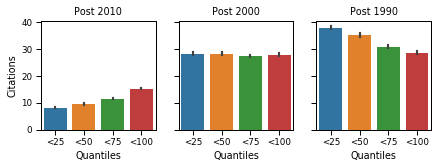

In [52]:
df_dblp_post_2010 = df_dblp[(df_dblp["year"] > 2010)]
df_dblp_post_2000 = df_dblp[(df_dblp["year"] > 2000)]
df_dblp_post_1990 = df_dblp[(df_dblp["year"] > 1990)]

sns.set_context("paper")
fig,ax = plt.subplots(1,3,figsize=[7,2],sharey=True)

sns.barplot(y='indeg',x='max_prog_q',data=df_dblp_post_2010,ax=ax[0]);
ax[0].set_title('Post 2010')
ax[0].set_xlabel('Quantiles')
ax[0].set_ylabel('Citations')

sns.barplot(y='indeg',x='max_prog_q',data=df_dblp_post_2000,ax=ax[1]);
ax[1].set_title('Post 2000');
ax[1].set_xlabel('Quantiles')
ax[1].set_ylabel('')

sns.barplot(y='indeg',x='max_prog_q',data=df_dblp_post_1990,ax=ax[2]);
ax[2].set_title('Post 1990');
ax[2].set_xlabel('Quantiles')
ax[2].set_ylabel('')

Looks much better.

- Post 2010, we see the expected trend ruling out the second explanation for the discrepancy.
- Post 2000, almost even.
- Post 1990, the trend reverses which aligns with the intuition that older papers get more popular because of their age.

Its still not ideal, but hopefully by controlling for age of the document in the multivariate analysis, we will get the right answer.

(perhaps also points to the limitation of our metric which tends to score more heavily on progressiveness for recent documents)

In [103]:
df_dblp_2000s = df_dblp[(df_dblp["year"] > 1980) & (df_dblp["year"] <= 2010)]
print (len(df_dblp_2000s))

748871


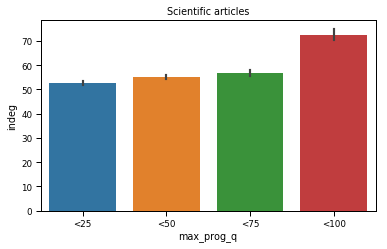

In [104]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
sns.barplot(y='indeg',x='max_prog_q',data=df_dblp_2000s,ax=ax);
ax.set_title('Scientific articles');

In [91]:
pd.IntervalIndex.from_tuples?

In [106]:
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 4), (4, np.inf)], closed="left")
df_dblp['nprog50_q'] = pd.cut (df_dblp["nprog50"], bins=bins, labels=["0", "<=2", "3+"], retbins=False, duplicates="drop")
df_dblp['nprog90_q'] = pd.cut (df_dblp["nprog90"], bins=bins, labels=["0", "<=2", "3+"], retbins=False, duplicates="drop")
df_dblp['nprog95_q'] = pd.cut (df_dblp["nprog95"], bins=bins, labels=["0", "<=2", "3+"], retbins=False, duplicates="drop")
df_dblp['nprog99_q'] = pd.cut (df_dblp["nprog99"], bins=bins, labels=["0", "<=2", "3+"], retbins=False, duplicates="drop")

In [108]:
df_dblp_2000s = df_dblp[(df_dblp["year"] > 1980) & (df_dblp["year"] <= 2010)]
print (len(df_dblp_2000s))

748871


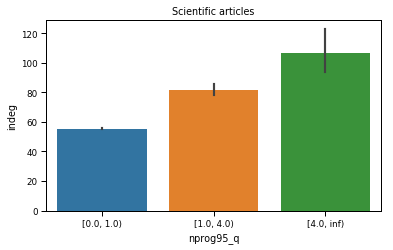

In [105]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
sns.barplot(y='indeg',x='nprog95_q',data=df_dblp_2000s,ax=ax);
ax.set_title('Scientific articles');

In [111]:
df_dblp_2000s.columns.values

array(['docid', 'indeg', 'outdeg', 'year', 'nauthors', 'nuniqs',
       'ntokens', 'lang', 'bows', 'nprog', 'nreg', 'max_prog',
       'max_prog_word', 'max_reg', 'max_reg_word', 'nprog99', 'nprog95',
       'nprog90', 'nprog50', 'nreg99', 'nreg95', 'nreg90', 'nreg50',
       'age', 'isUNK', 'max_prog_q', 'nprog95_q', 'nprog50_q',
       'nprog90_q', 'nprog99_q'], dtype=object)

Text(0, 0.5, '')

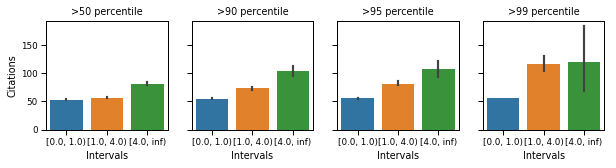

In [116]:
sns.set_context("paper")
fig,ax = plt.subplots(1,4,figsize=[10,2],sharey=True)

sns.barplot(y='indeg',x='nprog50_q',data=df_dblp_2000s,ax=ax[0]);
ax[0].set_title('>50 percentile')
ax[0].set_xlabel('Intervals')
ax[0].set_ylabel('Citations')


sns.barplot(y='indeg',x='nprog90_q',data=df_dblp_2000s,ax=ax[1]);
ax[1].set_title('>90 percentile');
ax[1].set_xlabel('Intervals')
ax[1].set_ylabel('')

sns.barplot(y='indeg',x='nprog95_q',data=df_dblp_2000s,ax=ax[2]);
ax[2].set_title('>95 percentile');
ax[2].set_xlabel('Intervals')
ax[2].set_ylabel('')

sns.barplot(y='indeg',x='nprog99_q',data=df_dblp_2000s,ax=ax[3]);
ax[3].set_title('>99 percentile');
ax[3].set_xlabel('Intervals')
ax[3].set_ylabel('')